In [2]:
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd
import PIL
from PIL import Image
import torchvision
import torch


import torch.nn.functional as F
from torchvision import utils, transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from sklearn.model_selection import KFold
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter


myseed = 1
torch.manual_seed(myseed)
np.random.seed(myseed)

%matplotlib inline

In [3]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cpu


In [4]:
data_path = "../../ADNI_pre-processing/"
filename = "ADNI_ready.csv"

adni = pd.read_csv(os.path.join(data_path, filename))
adni.head()

# Print 
print(f"Final data has {len(adni)}")

print(f"Class distribution is organized as follow:")
print(f"Final:\n {adni['labels'].value_counts()}")

Final data has 961
Class distribution is organized as follow:
Final:
 0    583
1    378
Name: labels, dtype: int64


### 2) Dataset creator

In [5]:
class TextDataset(Dataset):
    """Tabular and Image dataset."""

    def __init__(self, tabular_df):
        self.tabular = tabular_df
        
    def __len__(self):
        return len(self.tabular)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        tabular = self.tabular.iloc[idx, 0:]
        y = tabular["labels"]

        # 'PTGENDER',
        tabular = tabular[['AGE','PTGENDER','ADAS11', 'MMSE', 'FAQ', \
                           'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', \
                           'CDRSB', 'APOE4']]
        
        #tabular = tabular.to_list()
        #tabular = tabular.double()
        tabular = torch.FloatTensor(tabular)
        
        return tabular, y

text_data = TextDataset(tabular_df=adni)

### Randomize the train, val set generation

In [6]:
train_size = int(0.80 * len(text_data))
val_size = int((len(text_data) - train_size) / 2)
test_size = int(len(text_data) - train_size - val_size) 

# Test set will stay the same for all the folds. TV set will be used to get the train and val set with cross-valid
tv_set, test_set = random_split(text_data, (train_size + val_size, test_size), generator=torch.Generator().manual_seed(0))

# 2. SOLO TESTO

In [7]:
class TextNN(nn.Module):

    #Constructor
    def __init__(self, num_variables):
    # Call parent contructor
        super().__init__()
        torch.manual_seed(myseed)
        self.relu = nn.ReLU()
        self.ln1 = nn.Linear(num_variables, 50) #num_variables sono le colonne in input
        self.ln2 = nn.Linear(50, 50)
        self.ln3 = nn.Linear(50, 10)
        self.ln4 = nn.Linear(10, 1)
    
    def forward(self, tab):
        tab = self.ln1(tab)
        tab = self.relu(tab)
        tab = self.ln2(tab)
        tab = self.relu(tab)
        tab = self.ln3(tab)
        tab = self.relu(tab)
        tab = self.ln4(tab)

        return tab

model = TextNN(len(tv_set[0][0])) # required_columns - label column
print(model)

TextNN(
  (relu): ReLU()
  (ln1): Linear(in_features=10, out_features=50, bias=True)
  (ln2): Linear(in_features=50, out_features=50, bias=True)
  (ln3): Linear(in_features=50, out_features=10, bias=True)
  (ln4): Linear(in_features=10, out_features=1, bias=True)
)


In [8]:
tab_x, label_x = tv_set[0]
#img_x = img_x.unsqueeze(dim=0)
#img_x.size()
output = model(tab_x)
output.shape

torch.Size([1])

In [9]:
def train(net, loaders, optimizer, criterion, epochs=500, dev=dev, save_param = False, model_name="adni_only-text"):
    torch.manual_seed(myseed)
    try:
        net = net.to(dev)
        #print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Store the best val accuracy
        best_val_accuracy = 0

        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                    net.train()
                else:
                    net.eval()
                # Process each batch
                for (tabular, labels) in loaders[split]:
                    # Move to CUDA
                    tabular = tabular.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(tabular)
                    #pred = pred.squeeze(dim=1) # Output shape is [Batch size, 1], but we want [Batch size]
                    labels = labels.unsqueeze(1)
                    labels = labels.float()
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    #pred_labels = pred.argmax(1) + 1
                    pred_labels = (pred >= 0.5).long() # Binarize predictions to 0 and 1
                    batch_accuracy = (pred_labels == labels).sum().item()/tabular.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
                scheduler.step()
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}

            # Store params at the best validation accuracy
            if save_param and epoch_accuracy["val"] > best_val_accuracy:
                #torch.save(net.state_dict(), f"{net.__class__.__name__}_best_val.pth")
                torch.save(net.state_dict(), f"{model_name}_best_val.pth")
                best_val_accuracy = epoch_accuracy["val"]

            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
                
            writer.add_scalar("Train Loss", epoch_loss['train'], epoch)
            writer.add_scalar("Valid Loss", epoch_loss['val'], epoch)
            writer.add_scalar("Test Loss", epoch_loss['test'], epoch)
            writer.add_scalar("Train Accuracy", epoch_accuracy['train'], epoch)
            writer.add_scalar("Valid Accuracy", epoch_accuracy['val'], epoch)
            writer.add_scalar("Test Accuracy", epoch_accuracy['test'], epoch)
            
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},",
                  f"LR={optimizer.param_groups[0]['lr']:.5f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

In [10]:
def reset_weights(m):

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()


------------fold no---------0----------------------
Epoch 1: TrL=0.6841, TrA=0.7601, VL=0.6257, VA=0.9602, TeL=0.6193, TeA=0.9808, LR=0.00040,
Epoch 2: TrL=0.4383, TrA=0.9842, VL=0.2543, VA=0.9830, TeL=0.2666, TeA=0.9808, LR=0.00040,
Epoch 3: TrL=0.1157, TrA=0.9856, VL=0.0850, VA=0.9830, TeL=0.1052, TeA=0.9808, LR=0.00040,
Epoch 4: TrL=0.0599, TrA=0.9832, VL=0.0720, VA=0.9830, TeL=0.0967, TeA=0.9808, LR=0.00040,
Epoch 5: TrL=0.0491, TrA=0.9885, VL=0.0655, VA=0.9830, TeL=0.0928, TeA=0.9808, LR=0.00040,
Epoch 6: TrL=0.0452, TrA=0.9899, VL=0.0628, VA=0.9830, TeL=0.0919, TeA=0.9808, LR=0.00040,
Epoch 7: TrL=0.0424, TrA=0.9899, VL=0.0614, VA=0.9830, TeL=0.0912, TeA=0.9808, LR=0.00040,
Epoch 8: TrL=0.0401, TrA=0.9928, VL=0.0605, VA=0.9830, TeL=0.0911, TeA=0.9808, LR=0.00040,
Epoch 9: TrL=0.0385, TrA=0.9928, VL=0.0596, VA=0.9830, TeL=0.0898, TeA=0.9808, LR=0.00040,
Epoch 10: TrL=0.0376, TrA=0.9943, VL=0.0594, VA=0.9830, TeL=0.0898, TeA=0.9808, LR=0.00040,
Epoch 11: TrL=0.0357, TrA=0.9943, VL=

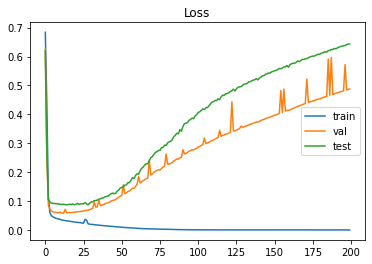

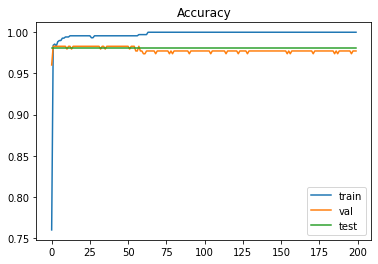

------------fold no---------1----------------------
Epoch 1: TrL=0.6317, TrA=0.6030, VL=0.5410, VA=0.6148, TeL=0.5518, TeA=0.6250, LR=0.00040,
Epoch 2: TrL=0.3822, TrA=0.6667, VL=0.1948, VA=0.9000, TeL=0.2238, TeA=0.8750, LR=0.00040,
Epoch 3: TrL=0.1373, TrA=0.9526, VL=0.0498, VA=0.9943, TeL=0.1028, TeA=0.9712, LR=0.00040,
Epoch 4: TrL=0.0714, TrA=0.9842, VL=0.0221, VA=1.0000, TeL=0.0948, TeA=0.9712, LR=0.00040,
Epoch 5: TrL=0.0593, TrA=0.9828, VL=0.0172, VA=1.0000, TeL=0.0922, TeA=0.9808, LR=0.00040,
Epoch 6: TrL=0.0546, TrA=0.9842, VL=0.0136, VA=1.0000, TeL=0.0923, TeA=0.9808, LR=0.00040,
Epoch 7: TrL=0.0520, TrA=0.9871, VL=0.0115, VA=1.0000, TeL=0.0931, TeA=0.9808, LR=0.00040,
Epoch 8: TrL=0.0498, TrA=0.9899, VL=0.0104, VA=1.0000, TeL=0.0929, TeA=0.9808, LR=0.00040,
Epoch 9: TrL=0.0483, TrA=0.9899, VL=0.0101, VA=1.0000, TeL=0.0921, TeA=0.9808, LR=0.00040,
Epoch 10: TrL=0.0479, TrA=0.9899, VL=0.0096, VA=1.0000, TeL=0.0913, TeA=0.9808, LR=0.00040,
Epoch 11: TrL=0.0457, TrA=0.9914, VL=

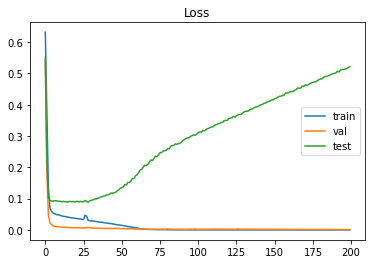

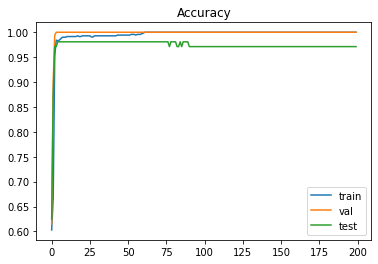

------------fold no---------2----------------------
Epoch 1: TrL=0.6312, TrA=0.5929, VL=0.5221, VA=0.6580, TeL=0.5444, TeA=0.6250, LR=0.00040,
Epoch 2: TrL=0.3774, TrA=0.6767, VL=0.1833, VA=0.9114, TeL=0.2178, TeA=0.9038, LR=0.00040,
Epoch 3: TrL=0.1300, TrA=0.9598, VL=0.0531, VA=0.9943, TeL=0.1034, TeA=0.9712, LR=0.00040,
Epoch 4: TrL=0.0685, TrA=0.9842, VL=0.0282, VA=0.9943, TeL=0.0973, TeA=0.9712, LR=0.00040,
Epoch 5: TrL=0.0581, TrA=0.9856, VL=0.0227, VA=0.9943, TeL=0.0946, TeA=0.9712, LR=0.00040,
Epoch 6: TrL=0.0532, TrA=0.9856, VL=0.0195, VA=0.9943, TeL=0.0954, TeA=0.9712, LR=0.00040,
Epoch 7: TrL=0.0510, TrA=0.9885, VL=0.0183, VA=1.0000, TeL=0.0958, TeA=0.9712, LR=0.00040,
Epoch 8: TrL=0.0492, TrA=0.9899, VL=0.0161, VA=1.0000, TeL=0.0953, TeA=0.9808, LR=0.00040,
Epoch 9: TrL=0.0479, TrA=0.9899, VL=0.0157, VA=1.0000, TeL=0.0952, TeA=0.9808, LR=0.00040,
Epoch 10: TrL=0.0476, TrA=0.9914, VL=0.0140, VA=1.0000, TeL=0.0944, TeA=0.9808, LR=0.00040,
Epoch 11: TrL=0.0456, TrA=0.9914, VL=

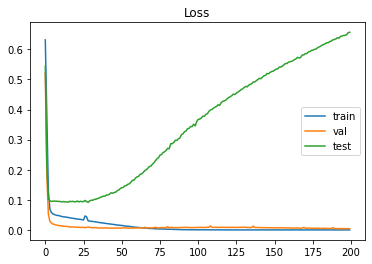

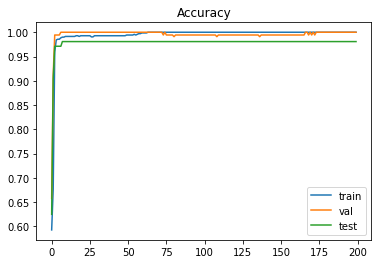

------------fold no---------3----------------------
Epoch 1: TrL=0.6205, TrA=0.6269, VL=0.5559, VA=0.5330, TeL=0.5349, TeA=0.6250, LR=0.00040,
Epoch 2: TrL=0.3550, TrA=0.6983, VL=0.2442, VA=0.8659, TeL=0.2154, TeA=0.8942, LR=0.00040,
Epoch 3: TrL=0.1160, TrA=0.9612, VL=0.1035, VA=0.9773, TeL=0.1022, TeA=0.9712, LR=0.00040,
Epoch 4: TrL=0.0522, TrA=0.9885, VL=0.0881, VA=0.9716, TeL=0.1000, TeA=0.9712, LR=0.00040,
Epoch 5: TrL=0.0416, TrA=0.9871, VL=0.0874, VA=0.9773, TeL=0.1015, TeA=0.9712, LR=0.00040,
Epoch 6: TrL=0.0368, TrA=0.9885, VL=0.0868, VA=0.9773, TeL=0.1040, TeA=0.9712, LR=0.00040,
Epoch 7: TrL=0.0352, TrA=0.9899, VL=0.0857, VA=0.9773, TeL=0.1038, TeA=0.9712, LR=0.00040,
Epoch 8: TrL=0.0337, TrA=0.9943, VL=0.0853, VA=0.9773, TeL=0.1030, TeA=0.9712, LR=0.00040,
Epoch 9: TrL=0.0329, TrA=0.9928, VL=0.0846, VA=0.9773, TeL=0.1040, TeA=0.9712, LR=0.00040,
Epoch 10: TrL=0.0325, TrA=0.9943, VL=0.0848, VA=0.9773, TeL=0.1040, TeA=0.9808, LR=0.00040,
Epoch 11: TrL=0.0309, TrA=0.9928, VL=

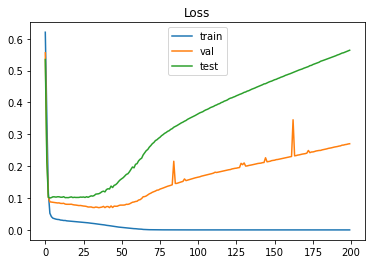

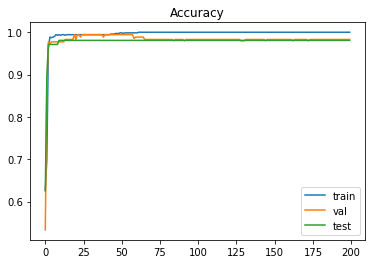

------------fold no---------4----------------------
Epoch 1: TrL=0.6252, TrA=0.6078, VL=0.5345, VA=0.6080, TeL=0.5383, TeA=0.6250, LR=0.00040,
Epoch 2: TrL=0.3667, TrA=0.6796, VL=0.2206, VA=0.8977, TeL=0.2182, TeA=0.8942, LR=0.00040,
Epoch 3: TrL=0.1266, TrA=0.9626, VL=0.0851, VA=0.9773, TeL=0.1041, TeA=0.9712, LR=0.00040,
Epoch 4: TrL=0.0584, TrA=0.9871, VL=0.0669, VA=0.9773, TeL=0.0972, TeA=0.9712, LR=0.00040,
Epoch 5: TrL=0.0463, TrA=0.9899, VL=0.0646, VA=0.9773, TeL=0.0975, TeA=0.9712, LR=0.00040,
Epoch 6: TrL=0.0421, TrA=0.9899, VL=0.0636, VA=0.9773, TeL=0.0980, TeA=0.9712, LR=0.00040,
Epoch 7: TrL=0.0394, TrA=0.9928, VL=0.0639, VA=0.9830, TeL=0.1009, TeA=0.9712, LR=0.00040,
Epoch 8: TrL=0.0380, TrA=0.9943, VL=0.0637, VA=0.9830, TeL=0.1000, TeA=0.9808, LR=0.00040,
Epoch 9: TrL=0.0378, TrA=0.9928, VL=0.0639, VA=0.9830, TeL=0.0996, TeA=0.9808, LR=0.00040,
Epoch 10: TrL=0.0357, TrA=0.9957, VL=0.0634, VA=0.9830, TeL=0.1019, TeA=0.9712, LR=0.00040,
Epoch 11: TrL=0.0347, TrA=0.9957, VL=

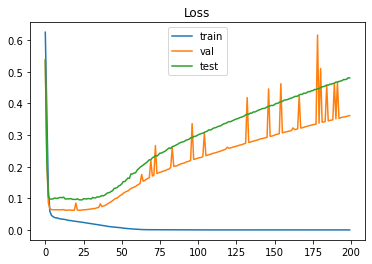

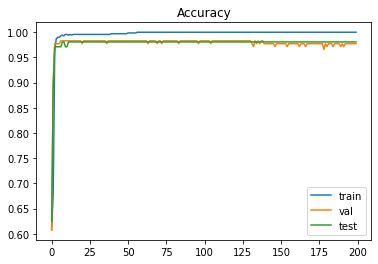

In [11]:
generator=torch.Generator()
generator.manual_seed(myseed)
test_loader = DataLoader(test_set,  batch_size=8, num_workers=0, drop_last=False, shuffle=False, generator=generator)

epochs = 200

kfold = KFold(n_splits=5)

for fold,(train_idx,test_idx) in enumerate(kfold.split(tv_set)):
    writer = SummaryWriter("runs/adni_txt-only", filename_suffix=f"F{fold}_E{epochs}_")
    print('------------fold no---------{}----------------------'.format(fold))
    train_subsampler = SubsetRandomSampler(train_idx)
    test_subsampler = SubsetRandomSampler(test_idx)

    train_loader = DataLoader(tv_set, batch_size=8, drop_last=False, sampler=train_subsampler)
    val_loader = DataLoader(tv_set, batch_size=8, drop_last=False, sampler=test_subsampler)
    
    # Define dictionary of loaders
    loaders = {"train": train_loader,
               "val": val_loader,
               "test": test_loader}

    # Model Params
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)
    # Define a loss 
    criterion = nn.BCEWithLogitsLoss()
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.01, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    
    # Train model
    train(model, loaders, optimizer, criterion, epochs=epochs, dev=dev)
    writer.flush()
    writer.close()
    model.apply(reset_weights)

In [ ]:
model.apply(reset_weights)

In [ ]:
writer.close()